### Importing Libaries

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

### Importing CNN architecture from models.py file

In [2]:
from models import Net

net = Net()
print(net)

Hello
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=136, bias=True)
)


In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# to load the dataset 
from data_load import FacialKeypointsDataset
# the transformations we want to apply on each image
from data_load import Rescale, RandomCrop, Normalize, ToTensor, Resize

## define the data_transform using transforms.Compose([all tx's, . , .])
data_transform = transforms.Compose([Resize(224),
                                     Normalize(),
                                     ToTensor()]) #Resize(224)

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


### Batching and loading data

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


### Before training

#### Load in the test dataset

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images
# returns: test images, test predicted keypoints, test ground truth keypoints
def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [9]:
# call the above function
test_images, test_outputs, gt_pts = net_sample_output()

# printing out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

In [10]:
"""
show_all_keypoints functions displays a grayscale image,
its predicted keypoints and its ground truth keypoints (if provided).
"""
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

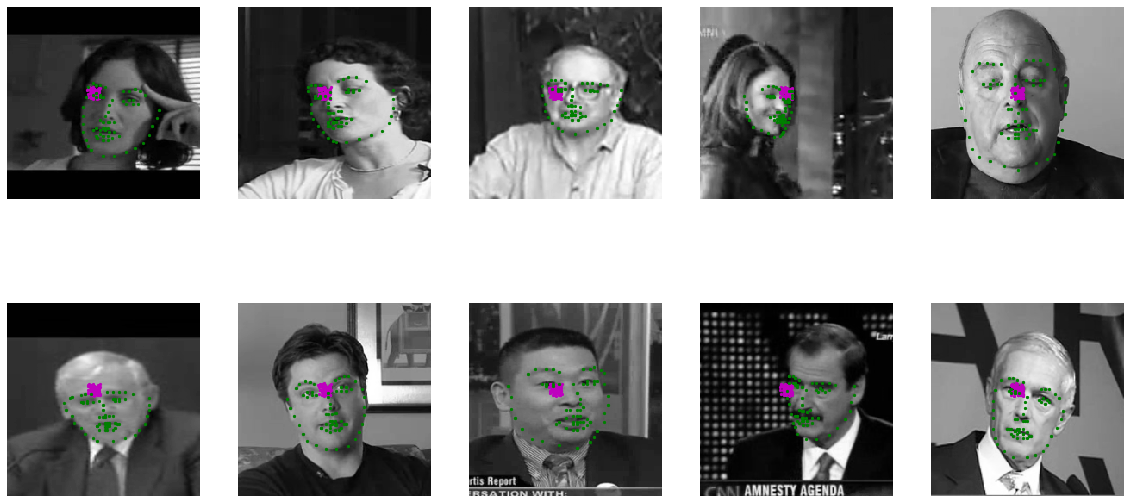

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    plt.figure(figsize=(20,10))
    for i in range(batch_size):
        
        plt.subplot(2, batch_size/2, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

### Initializing Loss and Optimizer

In [12]:
# Defining the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters())

### Training

In [13]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0033441822826862336
Epoch: 1, Batch: 20, Avg. Loss: 0.0026044446974992754
Epoch: 1, Batch: 30, Avg. Loss: 0.00190988427400589
Epoch: 1, Batch: 40, Avg. Loss: 0.0015493408739566802
Epoch: 1, Batch: 50, Avg. Loss: 0.0012909875363111495
Epoch: 1, Batch: 60, Avg. Loss: 0.0011417308524250985
Epoch: 1, Batch: 70, Avg. Loss: 0.001027258314192295
Epoch: 1, Batch: 80, Avg. Loss: 0.0009924028441309928
Epoch: 1, Batch: 90, Avg. Loss: 0.0009582457095384598
Epoch: 1, Batch: 100, Avg. Loss: 0.000985388733446598
Epoch: 1, Batch: 110, Avg. Loss: 0.0008360456004738808
Epoch: 1, Batch: 120, Avg. Loss: 0.0008946060314774513
Epoch: 1, Batch: 130, Avg. Loss: 0.0009123900160193443
Epoch: 1, Batch: 140, Avg. Loss: 0.0008388074263930321
Epoch: 1, Batch: 150, Avg. Loss: 0.0008980173096060752
Epoch: 1, Batch: 160, Avg. Loss: 0.0007800690010190011
Epoch: 1, Batch: 170, Avg. Loss: 0.0008238568231463433
Epoch: 2, Batch: 10, Avg. Loss: 0.0008474549204111099
Epoch: 2, Batch: 20, Avg

Epoch: 9, Batch: 160, Avg. Loss: 0.0006772250942885876
Epoch: 9, Batch: 170, Avg. Loss: 0.0006840277425944805
Epoch: 10, Batch: 10, Avg. Loss: 0.0006852227188646794
Epoch: 10, Batch: 20, Avg. Loss: 0.0006828522793948651
Epoch: 10, Batch: 30, Avg. Loss: 0.0006171102710068226
Epoch: 10, Batch: 40, Avg. Loss: 0.0006006403453648091
Epoch: 10, Batch: 50, Avg. Loss: 0.0007038100436329842
Epoch: 10, Batch: 60, Avg. Loss: 0.0006089746654033661
Epoch: 10, Batch: 70, Avg. Loss: 0.0005642756931483746
Epoch: 10, Batch: 80, Avg. Loss: 0.0006460146568715572
Epoch: 10, Batch: 90, Avg. Loss: 0.0006643446087837219
Epoch: 10, Batch: 100, Avg. Loss: 0.0007273255623877049
Epoch: 10, Batch: 110, Avg. Loss: 0.000624178733676672
Epoch: 10, Batch: 120, Avg. Loss: 0.0006692146733403206
Epoch: 10, Batch: 130, Avg. Loss: 0.0006867691241204738
Epoch: 10, Batch: 140, Avg. Loss: 0.0006049529388546944
Epoch: 10, Batch: 150, Avg. Loss: 0.0006495175473392009
Epoch: 10, Batch: 160, Avg. Loss: 0.0005747815519571304
Epoc

## Test data

To check how our model performs on previously unseen, test data.

In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


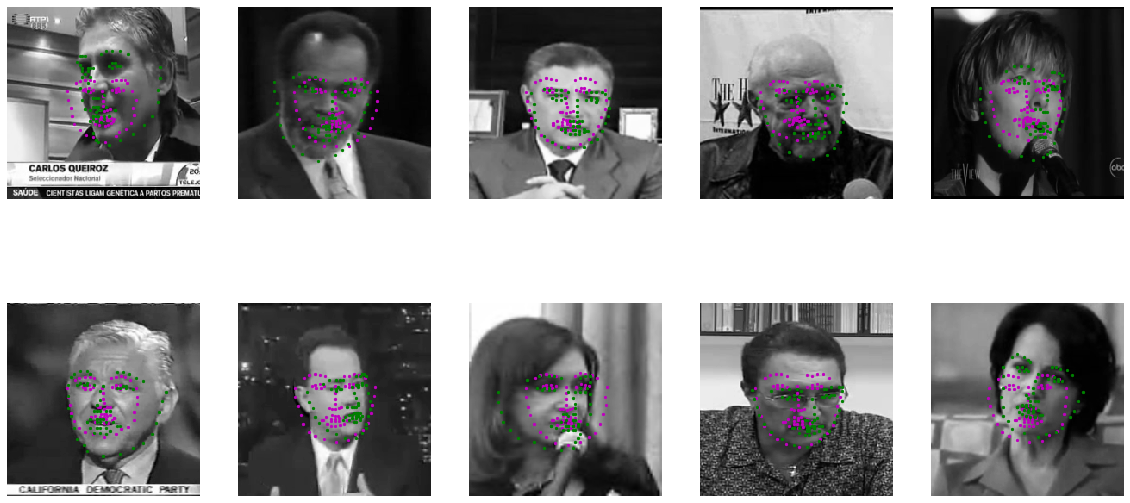

In [16]:
# calling visualize_output to visualize some of the test images and facial keypoints:
visualize_output(test_images, test_outputs, gt_pts)

### Model Saving
Once we've found a good model (or two), save our model is good so that we can load it and use it later!

In [17]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_3.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)